### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSBBSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12655
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|    36|[00 7E 00 7E 00 7...|1998.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     1|[80 54 30 54 40 C...|1999.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     3|[30 55 E0 55 80 5...|2000.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     3|[20 50 80 51 00 4...|2001.0|SBSBBSSB|
|    124.1| 46.2667|-119.1167|       TMAX|USW00024163|     1|[E0 50 80 51 30 5...|2002.0|SBSBBSSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
#print STAT
#print STAT_Descriptions
#df.show(200)
print df["vector"]

Column<vector>


### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00024163')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(15)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)
print T

SELECT vector FROM weather
	WHERE measurement='TMAX' and station='USW00024163'
15 rows
+--------------------+
|              vector|
+--------------------+
|[00 7E 00 7E 00 7...|
|[80 54 30 54 40 C...|
|[30 55 E0 55 80 5...|
|[20 50 80 51 00 4...|
|[E0 50 80 51 30 5...|
|[80 54 50 57 58 5...|
|[00 46 00 46 00 C...|
|[80 49 00 00 40 C...|
|[F0 56 90 55 E0 5...|
|[80 49 80 58 50 5...|
|[40 4C 00 46 80 4...|
|[40 56 A0 53 C0 D...|
|[90 55 E0 55 20 5...|
|[00 D0 00 CC C0 C...|
|[A0 53 E0 50 40 5...|
+--------------------+

[[         nan          nan          nan ...,  15.          12.796875
   13.8984375 ]
 [  7.19921875   6.69921875  -1.70019531 ...,   0.          -0.60009766
    1.09960938]
 [  8.296875     9.3984375    4.3984375  ...,   2.19921875   2.80078125
    3.90039062]
 ..., 
 [  8.8984375    9.3984375    3.30078125 ...,   7.19921875   1.70019531
   -1.59960938]
 [ -3.19921875  -1.59960938  -2.69921875 ...,  13.8984375   12.203125
    7.19921875]
 [  6.1015625    3.90039062  10.

### Script for plotting yearly plots

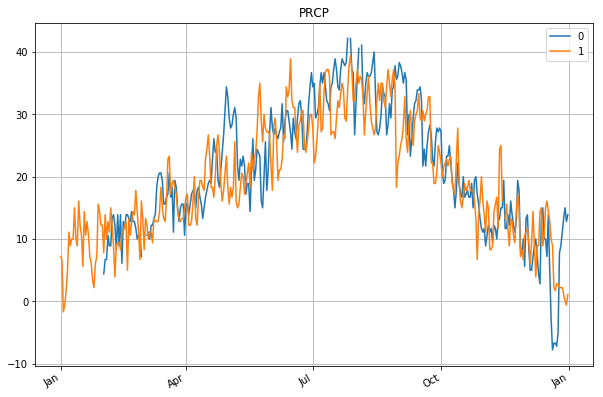

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


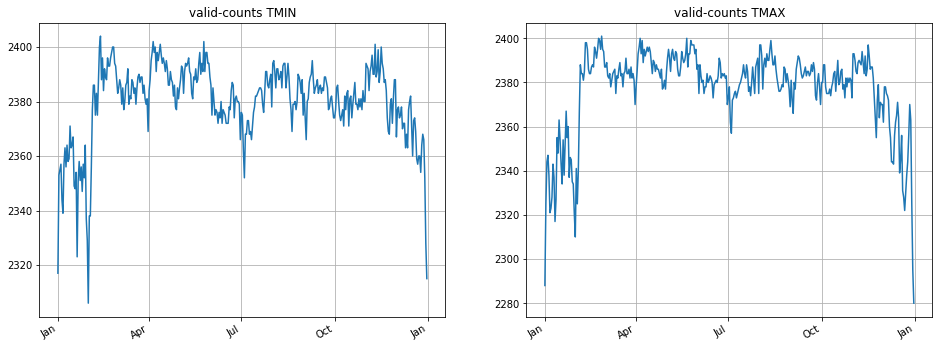

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

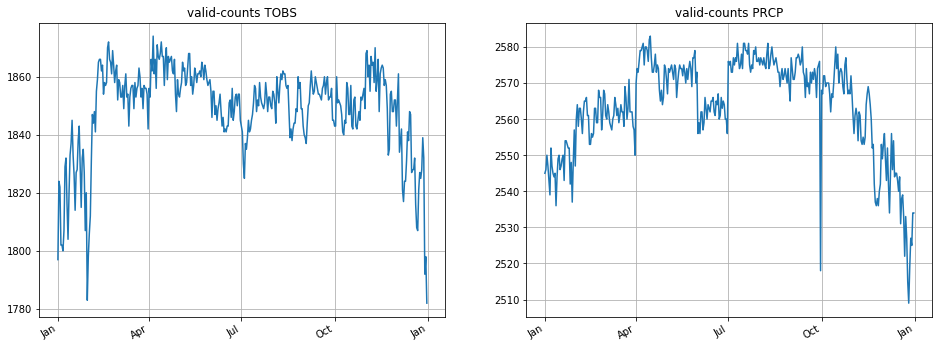

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

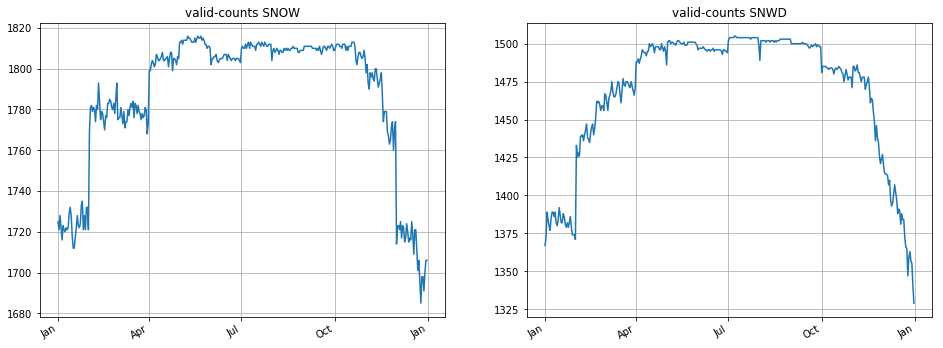

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [30]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10*9/5+32
    std=np.sqrt(STAT[m]['Var'])/10*9/5
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

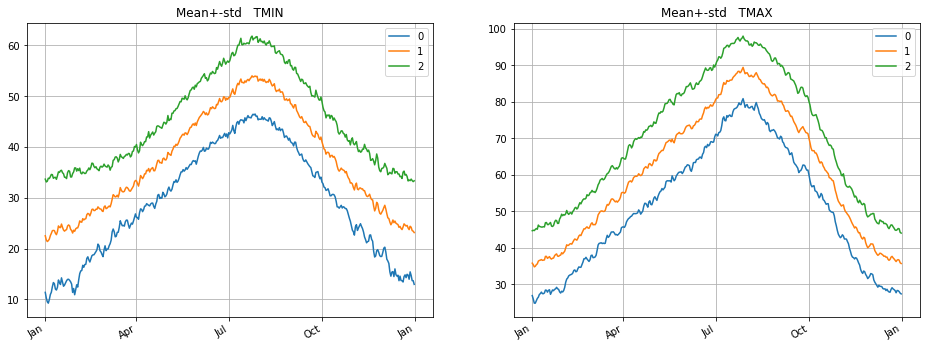

In [31]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

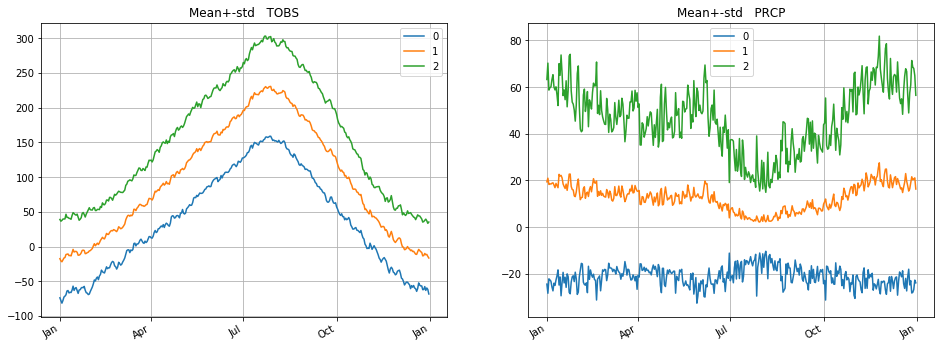

In [29]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

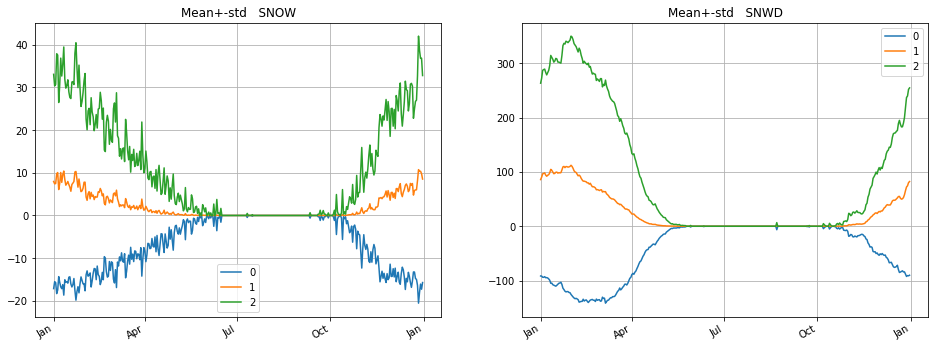

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

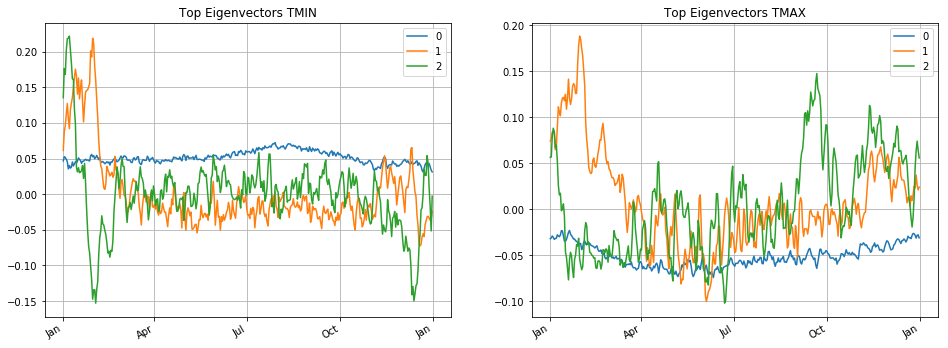

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

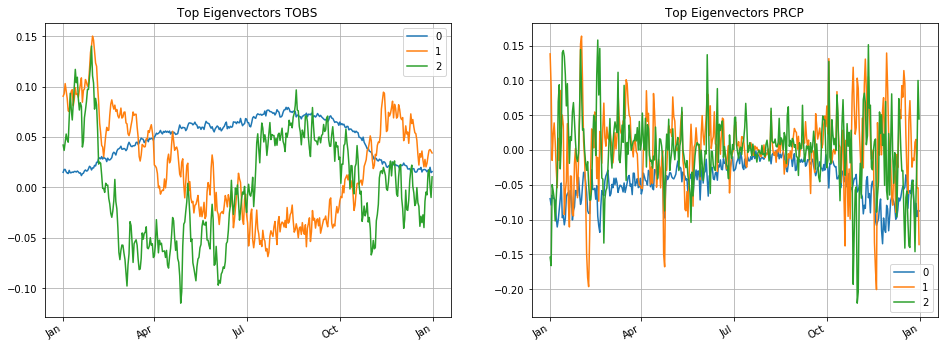

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

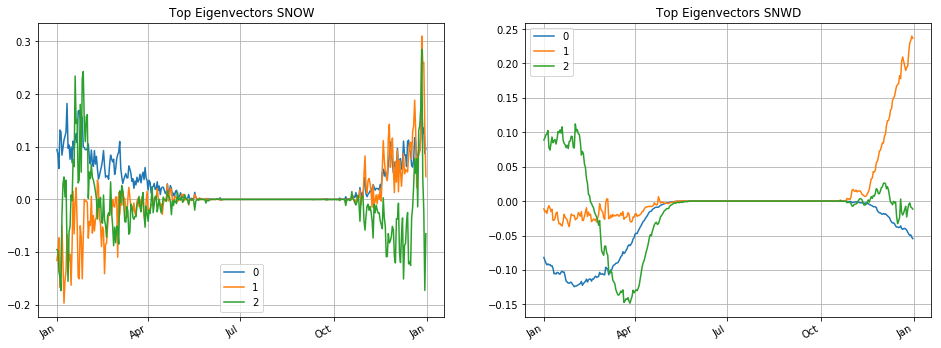

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [17]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

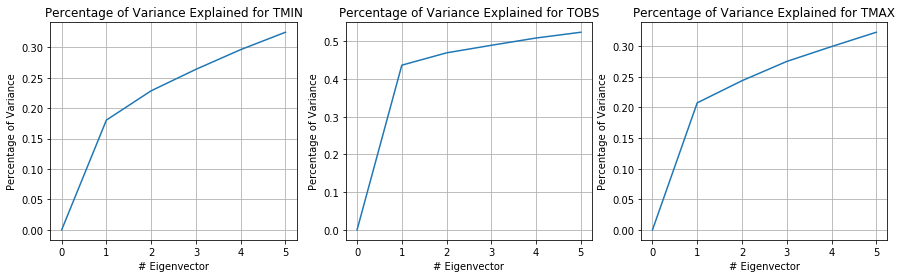

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

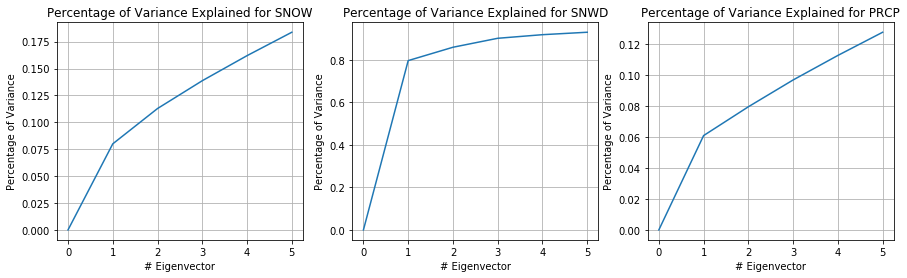

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [20]:
#sc.stop()